In [1]:
from scipy.spatial import distance
import pickle
import torch
from torch import linalg
import numpy as np
from scipy.linalg import cho_solve

/Users/patricktourniaire/opt/miniconda3/envs/nmmm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_object(repo: str, file: str):
    # Path constant to save the object
    PATH = f'{repo}/{file}.pkl'

    with open(PATH, 'rb') as f:
        return pickle.load(f)

In [5]:
features = load_object('../../data/train', 'ring')
features = torch.from_numpy(features)

In [6]:
features

tensor([[ 4.8302,  1.7729],
        [-3.0147,  3.6299],
        [-2.7704, -4.4909],
        ...,
        [ 4.9549, -0.0193],
        [-3.0155, -3.9369],
        [ 5.2306,  0.5260]], dtype=torch.float64)

In [61]:
C = 1000
D = 2

means = torch.zeros(C, D, dtype=torch.float64).normal_(0, 0.5)

mu0 = means[0]
mu1 = means[1]

In [129]:
L = torch.normal(2, 0.5, size=(C, 1, 1)) * torch.eye(D, D).view(1, D, D)
sigmas = (L).type(torch.float64).contiguous()
print(sigmas[0])
print(torch.tril(sigmas[0]))
S0 = torch.tril(sigmas[0]) @ torch.tril(sigmas[0]).t()
S1 = torch.tril(sigmas[1]) @ torch.tril(sigmas[1]).t()

print(mu0, mu1, S0, S1)

tensor([[1.6055, 0.0000],
        [0.0000, 1.6055]], dtype=torch.float64)
tensor([[1.6055, 0.0000],
        [0.0000, 1.6055]], dtype=torch.float64)
tensor([-0.2347,  0.2017], dtype=torch.float64) tensor([0.6499, 0.1930], dtype=torch.float64) tensor([[2.5778, 0.0000],
        [0.0000, 2.5778]], dtype=torch.float64) tensor([[2.7873, 0.0000],
        [0.0000, 2.7873]], dtype=torch.float64)


In [130]:
def _sqrd_params(Si, Sj, mui, muj) -> torch.Tensor:
        # Compute the squared Gaussian params
        sigma = torch.inverse(torch.inverse(Si) + torch.inverse(Sj))
        mu = sigma @ (torch.inverse(Si) @ mui + torch.inverse(Si) @ muj)

        return (sigma, mu)

cluster_ids = torch.Tensor(range(C))
cartesian_ids = torch.cartesian_prod(cluster_ids, cluster_ids)
cartesian_ids = cartesian_ids.data.cpu().numpy().astype(int)

recomputed_params = {
    'means': [],
    'sigmas': []
}

for (i, j) in cartesian_ids:
    Si = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    Sj = torch.tril(sigmas[j]) @ torch.tril(sigmas[j]).t()
    
    sigma, mean = _sqrd_params(Si, Sj, means[i], means[j])
    
    recomputed_params['sigmas'].append(sigma.data.cpu().numpy())
    recomputed_params['means'].append(mean.data.cpu().numpy())

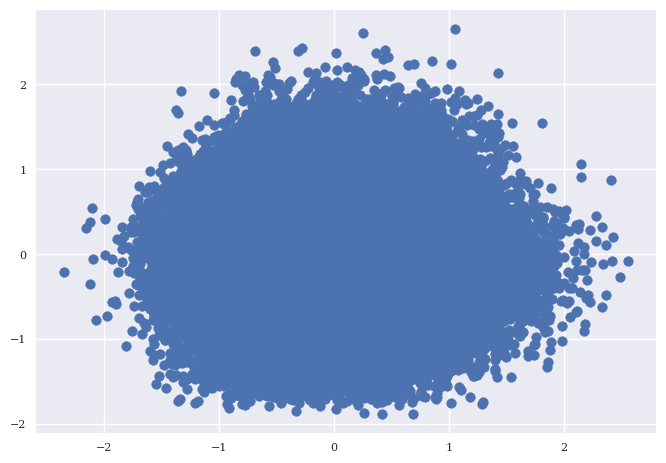

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.array(recomputed_params['means'])[:,0], np.array(recomputed_params['means'])[:,1])
plt.show()

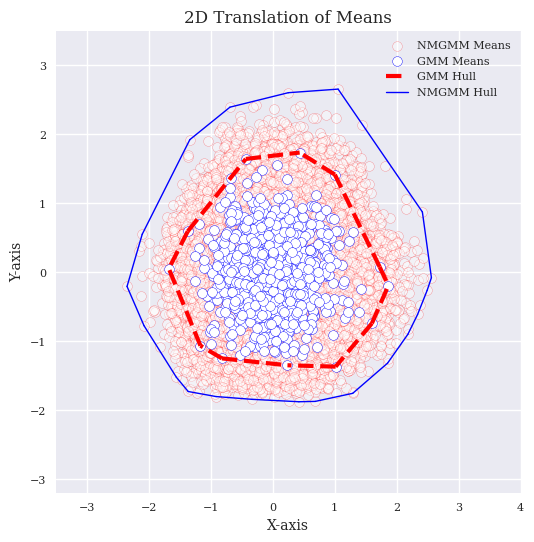

<Figure size 800x550 with 0 Axes>

In [132]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

plt.style.use('seaborn')


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8
}

plt.rcParams.update(tex_fonts)


hull1 = ConvexHull(means)
hull2 = ConvexHull(np.array(recomputed_params['means']))

fig, ax = plt.subplots(figsize=(6,6))

ax.set_title(r'2D Translation of Means')
ax.set_xlabel(r'X-axis')
ax.set_ylabel(r'Y-axis')

ax.set_xlim(-3.5, 4)
ax.set_ylim(-3.2, 3.5)

nmgmm_points = ax.scatter(
                np.array(recomputed_params['means'])[:,0],
                np.array(recomputed_params['means'])[:,1], 
                color='white',
                edgecolors='r',
                alpha=0.4,
                label='NMGMM Means')

gmm_points = ax.scatter(
                means[:,0], 
                means[:,1],
                color='white',
                edgecolors='blue',
                label='GMM Means')

for simplex in hull1.simplices:
    gmm_hull = ax.plot(
        means[simplex, 0],
        means[simplex, 1],
        'r--',
        linewidth=3,
        label='GMM Hull'
    )

for simplex in hull2.simplices:
    nmgmm_hull = ax.plot(
        np.array(recomputed_params['means'])[simplex, 0],
        np.array(recomputed_params['means'])[simplex, 1], 
        'b-',
        linewidth=1,
        label='NMGMM Hull'
    )

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=1)

plt.show()
plt.draw()
fig.savefig('convexhull_mean_translations.png')

In [133]:
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def _confidence_ellipse(ax, sigma, mu, n_std=2.3, facecolor='none', **kwargs):
        pearson = sigma[0][1]/np.sqrt(sigma[0][0] * sigma[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(sigma[0][0]) * n_std
        mean_x = mu[0]

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(sigma[1][1]) * n_std
        mean_y = mu[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def plot_contours(means, sigmas):
        _, ax = plt.subplots()

        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)

        for i in range(C):
            sigma = sigmas[i]
            mu = means[i]
            
            config = {
                'alpha': .2
            }

            _confidence_ellipse(ax, sigma, mu, **config)
            ax.scatter(mu[0], mu[1], c='red', s=3)
        
        plt.plot()

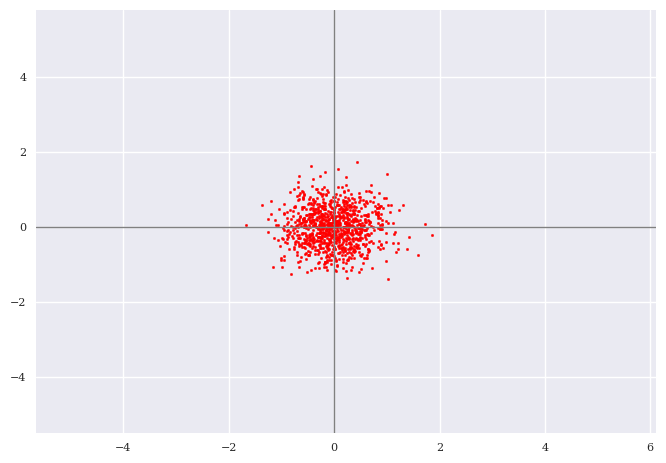

In [121]:
plot_contours(means.data.cpu().numpy(), sigmas.data.cpu().numpy())

In [134]:
sqrd_gen_variance = []

for i in range(C):
    S = recomputed_params['sigmas'][i]
    sqrd_gen_variance.append(np.linalg.det(S))

sqrd_gen_variance = np.array(sqrd_gen_variance)
sqrd_gen_variance

array([1.66121703, 1.79353984, 3.11505985, 3.53978602, 3.49882073,
       4.29610489, 3.50619623, 0.60026272, 1.56331722, 0.65879302,
       2.80360079, 2.75620954, 1.20745032, 2.13328026, 3.5179474 ,
       3.55365245, 3.48331762, 1.22959731, 1.36912924, 3.56838583,
       1.56938717, 1.68114941, 3.27165118, 1.84626698, 3.5897574 ,
       0.79870398, 3.34741068, 3.19377524, 1.46240328, 2.06731363,
       2.06537814, 3.08477441, 2.38768515, 1.86676878, 1.65796398,
       3.55718691, 3.67859459, 1.17396159, 1.44084513, 2.60844942,
       2.6769707 , 2.3803517 , 3.76557502, 1.66223042, 4.00291182,
       2.27101421, 2.65192232, 2.46306224, 2.8317539 , 2.10673999,
       2.19467854, 3.11528512, 2.12278848, 1.33666768, 2.3092816 ,
       3.69214508, 3.69102759, 3.39713632, 2.22972302, 1.85832611,
       2.25215388, 1.65564168, 3.23104123, 3.5282728 , 3.67916793,
       2.85864737, 2.79411358, 2.84613545, 1.63627702, 3.4321781 ,
       0.86570732, 1.94975892, 3.57117755, 2.56721607, 3.32957

In [135]:
gen_variance = []

for i in range(C):
    S = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    S = S.data.cpu().numpy()
    
    gen_variance.append(np.linalg.det(S))

gen_variance = np.array(gen_variance)
gen_variance

array([6.64486812e+00, 7.76930471e+00, 3.13309571e+01, 4.85098957e+01,
       4.64794858e+01, 1.11911896e+02, 4.68380930e+01, 1.22697941e+00,
       5.89529345e+00, 1.40346970e+00, 2.28282506e+01, 2.17525496e+01,
       3.66829359e+00, 1.13574568e+01, 4.74156967e+01, 4.92189845e+01,
       4.57354028e+01, 3.78677492e+00, 4.59125531e+00, 4.99848873e+01,
       5.93986571e+00, 6.80577080e+00, 3.67627486e+01, 8.25620582e+00,
       5.11192649e+01, 1.87135500e+00, 3.97368529e+01, 3.39485793e+01,
       5.18902563e+00, 1.05711491e+01, 1.05487887e+01, 3.03800252e+01,
       1.48812970e+01, 8.45189189e+00, 6.61888190e+00, 4.94015386e+01,
       5.61495693e+01, 3.49367601e+00, 5.04633280e+00, 1.87021541e+01,
       2.00622422e+01, 1.47675845e+01, 6.16156280e+01, 6.65297892e+00,
       7.98833091e+01, 1.31616153e+01, 1.95545453e+01, 1.60967993e+01,
       2.34916063e+01, 1.10353712e+01, 1.21334154e+01, 3.13381438e+01,
       1.12291922e+01, 4.39483249e+00, 1.37051399e+01, 5.69641766e+01,
      

<BarContainer object of 2 artists>

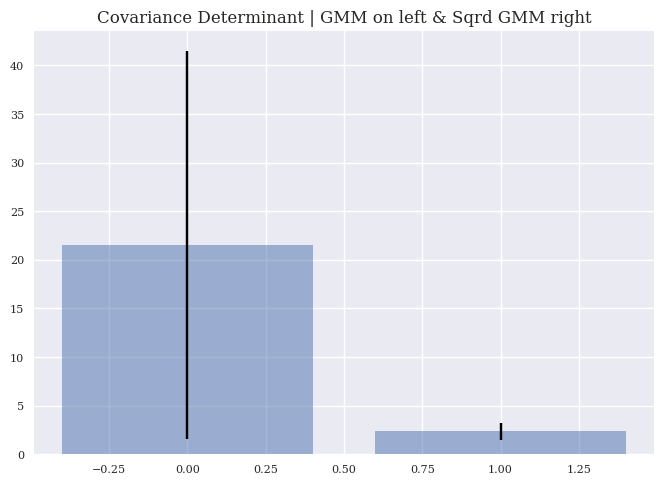

In [136]:
plt.title('Covariance Determinant | GMM on left & Sqrd GMM right')
plt.bar((0, 1), (gen_variance.mean(), sqrd_gen_variance.mean()), yerr=(gen_variance.std(), sqrd_gen_variance.std()), align='center', alpha=0.5)



In [137]:
print(sqrd_gen_variance.mean() - gen_variance.mean())

-19.13311712784946


[<matplotlib.patches.Patch object at 0x7f7fe79614e0>, <matplotlib.patches.Patch object at 0x7f7fe79614e0>]


<Figure size 800x550 with 0 Axes>

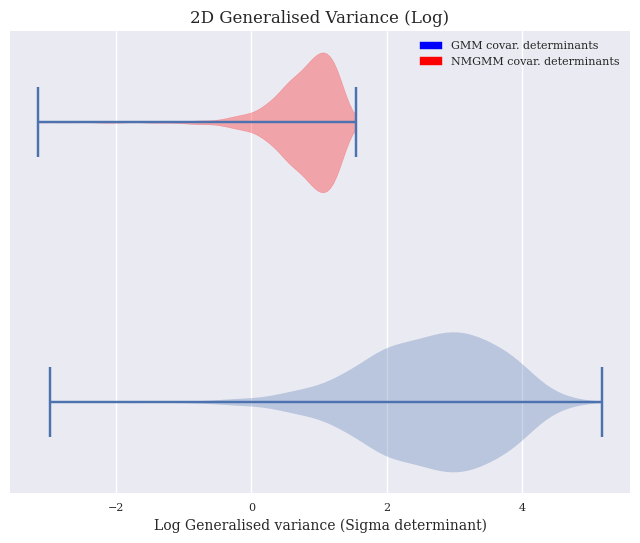

<Figure size 800x550 with 0 Axes>

In [138]:
import matplotlib.patches as mpatches
from itertools import repeat
    
fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yticks([], [])

ax.set_title('2D Generalised Variance (Log)')
ax.set_xlabel('Log Generalised variance (Sigma determinant)')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([np.log(gen_variance), np.log(sqrd_gen_variance)], vert=False)
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance_log.png')

[<matplotlib.patches.Patch object at 0x7f8005e32ec0>, <matplotlib.patches.Patch object at 0x7f8005e32ec0>]


<Figure size 800x550 with 0 Axes>

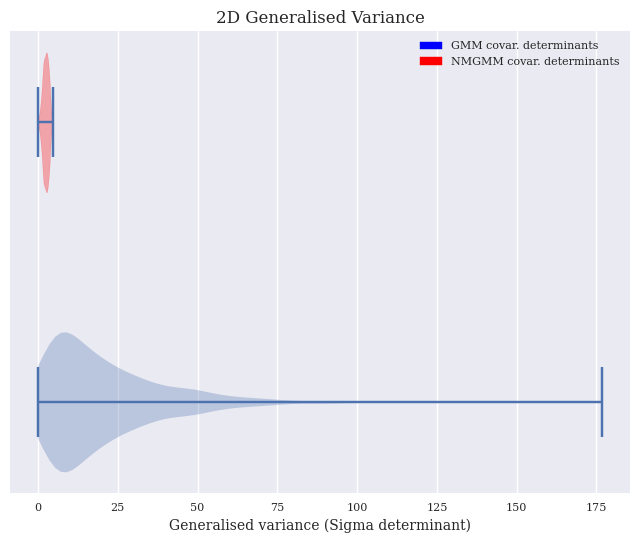

<Figure size 800x550 with 0 Axes>

In [139]:
import matplotlib.patches as mpatches
from itertools import repeat
    
fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yticks([], [])

ax.set_title('2D Generalised Variance')
ax.set_xlabel('Generalised variance (Sigma determinant)')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([gen_variance, sqrd_gen_variance], vert=False)
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance.png')